In [90]:
from functools import reduce
import re
import tarfile

import numpy as np

from keras.utils.data_utils import get_file
from keras.layers.embeddings import Embedding
from keras import layers
from keras.layers import recurrent, Bidirectional
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences


def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.

    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split(r'(\W+)?', sent) if x.strip()]


def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format

    If only_supporting is true,
    only the sentences that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


def get_stories(f, only_supporting=False, max_length=None):
    '''Given a file name, read the file, retrieve the stories,
    and then convert the sentences into a single story.

    If max_length is supplied,
    any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data
            if not max_length or len(flatten(story)) < max_length]
    return data


def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    xs = []
    xqs = []
    ys = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        xs.append(x)
        xqs.append(xq)
        ys.append(y)
    return (pad_sequences(xs, maxlen=story_maxlen),
            pad_sequences(xqs, maxlen=query_maxlen), np.array(ys))

RNN = recurrent.LSTM
EMBED_HIDDEN_SIZE = 100
SENT_HIDDEN_SIZE = 100
QUERY_HIDDEN_SIZE = 100
BATCH_SIZE = 32
EPOCHS = 5
print('RNN / Embed / Sent / Query = {}, {}, {}, {}'.format(RNN,
                                                           EMBED_HIDDEN_SIZE,
                                                           SENT_HIDDEN_SIZE,
                                                           QUERY_HIDDEN_SIZE))



RNN / Embed / Sent / Query = <class 'keras.layers.recurrent.LSTM'>, 100, 100, 100


In [91]:
try:
    path = get_file('babi-tasks-v1-2.tar.gz',
                    origin='https://s3.amazonaws.com/text-datasets/'
                           'babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2'
          '.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise



In [92]:
# Default QA1 with 1000 samples
#challenge = 'tasks_1-20_v1-2/en/qa1_single-supporting-fact_{}.txt'
# QA1 with 10,000 samples
# challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'
# QA2 with 1000 samples
#challenge = 'tasks_1-20_v1-2/en/qa2_two-supporting-facts_{}.txt'
# QA2 with 10,000 samples
challenge = 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt'
with tarfile.open(path) as tar:
    train = get_stories(tar.extractfile(challenge.format('train')))
    test = get_stories(tar.extractfile(challenge.format('test')))

vocab = set()
for story, q, answer in train + test:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
story_maxlen = max(map(len, (x for x, _, _ in train + test)))
query_maxlen = max(map(len, (x for _, x, _ in train + test)))

x, xq, y = vectorize_stories(train, word_idx, story_maxlen, query_maxlen)
tx, txq, ty = vectorize_stories(test, word_idx, story_maxlen, query_maxlen)

print('vocab = {}'.format(vocab))
print('x.shape = {}'.format(x.shape))
print('xq.shape = {}'.format(xq.shape))
print('y.shape = {}'.format(y.shape))
print('story_maxlen, query_maxlen = {}, {}'.format(story_maxlen, query_maxlen))



/Users/jdumoulin/Envs/python3notebooks/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


vocab = ['.', '?', 'Daniel', 'John', 'Mary', 'Sandra', 'Where', 'apple', 'back', 'bathroom', 'bedroom', 'discarded', 'down', 'dropped', 'football', 'garden', 'got', 'grabbed', 'hallway', 'is', 'journeyed', 'kitchen', 'left', 'milk', 'moved', 'office', 'picked', 'put', 'the', 'there', 'to', 'took', 'travelled', 'up', 'went']
x.shape = (10000, 552)
xq.shape = (10000, 5)
y.shape = (10000, 36)
story_maxlen, query_maxlen = 552, 5


In [95]:
print('Build model...')

sentence = layers.Input(shape=(story_maxlen,), dtype='int32')
encoded_sentence = layers.Embedding(vocab_size, EMBED_HIDDEN_SIZE)(sentence)
encoded_sentence = RNN(SENT_HIDDEN_SIZE, dropout=0.4, recurrent_dropout=0.4)(encoded_sentence)

question = layers.Input(shape=(query_maxlen,), dtype='int32')
encoded_question = layers.Embedding(vocab_size, EMBED_HIDDEN_SIZE)(question)
encoded_question = RNN(QUERY_HIDDEN_SIZE, dropout=0.4, recurrent_dropout=0.4)(encoded_question)

merged = layers.concatenate([encoded_sentence, encoded_question])
dense = layers.Dense(100)(merged)
drop = layers.Dropout(0.5)(dense)
preds = layers.Dense(vocab_size, activation='softmax')(drop)

#model = Model([sentence, question], preds)
#model.compile(optimizer='rmsprop',
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])




Build model...


In [96]:
print('Training')
hist = model.fit([x, xq], y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.05)


Training
Train on 9500 samples, validate on 500 samples
Epoch 1/5
9500/9500 [==============================] - 177s 19ms/step - loss: 0.8727 - acc: 0.6552 - val_loss: 1.4042 - val_acc: 0.4420
Epoch 2/5
9500/9500 [==============================] - 173s 18ms/step - loss: 0.8574 - acc: 0.6563 - val_loss: 1.4087 - val_acc: 0.4380
Epoch 3/5
9500/9500 [==============================] - 173s 18ms/step - loss: 0.8422 - acc: 0.6684 - val_loss: 1.4076 - val_acc: 0.4520
Epoch 4/5
9500/9500 [==============================] - 172s 18ms/step - loss: 0.8461 - acc: 0.6632 - val_loss: 1.4206 - val_acc: 0.4420
Epoch 5/5
9500/9500 [==============================] - 172s 18ms/step - loss: 0.8249 - acc: 0.6701 - val_loss: 1.4185 - val_acc: 0.4560


In [97]:
print('Evaluation')
loss, acc = model.evaluate([tx, txq], ty,
                           batch_size=BATCH_SIZE)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

Evaluation
1000/1000 [==============================] - 3s 3ms/step
Test loss / test accuracy = 1.5448 / 0.4260


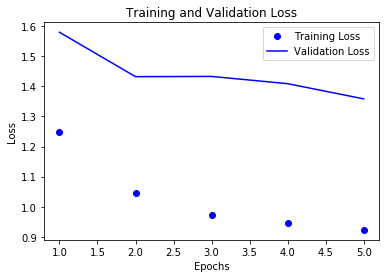

In [88]:
import matplotlib.pyplot as plt

history_dict = hist.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, EPOCHS + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

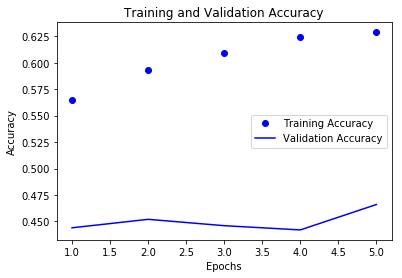

In [89]:
plt.clf()

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()